# Dictionary based time series classification in aeon

Dictionary based approaches adapt the bag of words model commonly used in signal processing, computer vision and audio processing for time series classification. Like shapelet based algorithms, dictionary approaches use phase-independent subsequences by sliding a window over time series. However, rather than to measure the distance to a subsequence, as in shapelets, each window is transformed into a word, and the frequency of occurrence of repeating patterns is recorded. Algorithms following the dictionary model build a classifier by:

- Extracting subseries, aka windows, from a time series:
- Transforming each window of real values into a discrete-valued word (a sequence of
symbols over a fixed alphabet);
- Building a sparse feature vector of histograms of word counts; and
- Finally using a classification method from the machine learning repertoire on these feature vectors.
The figure illustrates these steps from a raw time series to a dictionary model using overlapping windows.

<img src="./img/dictionary.png" width="800" alt="Dictionary based time series
classification"> [<i>&#x200B;</i>](./img/dictionary.png)

Dictionary-based methods differ in the way they transform a window of real-valued
measurements into discrete words (a process commonly called discretisation) in Step 2.
Many methods are based on a representation called Symbolic Fourier Approximation
(SFA). To create a discrete word from a window of continuous values in a series, SFA
follows the following steps:
- Values in each window are normalized to have standard deviation of 1.
- The dimensionality of each normalized window is reduced by the use of the truncated
Fourier transform: the window subseries is transformed using as fast Fourier transform,
and only the first few coefficients are retained.
- Each coefficient is discretised into a symbol from an alphabet a fixed size to
form a word.

Creating words from windows requires three parameters:
- 'window_size' specifies how long each window is;
- 'length' specifies the reduced series length used in reducing the length of the
real valued window; and
- 'alphabet_size' is the number of letters in the alphabet used in the discretisation.

These core parameters are often fixed internally. There are currently four dictionary
 based classifiers implemented in aeon, all making use of the Symbolic Fourier Approximation (SFA)\[1\] transform to discretise into words. These are the Bag of SFA Symbols (BOSS)\[2\], the Contractable Bag of SFA Symbols (cBOSS)\[3\], Word Extraction for Time Series Classification  (WEASEL)\[4\] and the Temporal Dictionary Ensemble (TDE)\[5\]. WEASEL has a multivariate extension called MUSE\[8\] and TDE has multivariate capability. We summarise their characteristics and give example usage in this notebook. More technical details are available in \[8\].


## Imports and Load Data



In [1]:
import warnings

from sklearn import metrics

from aeon.classification.dictionary_based import (
    MUSE,
    WEASEL,
    BOSSEnsemble,
    ContractableBOSS,
    IndividualBOSS,
    TemporalDictionaryEnsemble,
)
from aeon.datasets import load_basic_motions, load_italy_power_demand
from aeon.registry import all_estimators

warnings.filterwarnings("ignore")
all_estimators(
    "classifier", filter_tags={"algorithm_type": "dictionary"}, as_dataframe=True
)

,name,estimator
0,BOSSEnsemble,<class 'aeon.classification.dictionary_based._...
1,ContractableBOSS,<class 'aeon.classification.dictionary_based._...
2,MUSE,<class 'aeon.classification.dictionary_based._...
3,OrdinalTDE,<class 'aeon.classification.ordinal_classifica...
4,TemporalDictionaryEnsemble,<class 'aeon.classification.dictionary_based._...
5,WEASEL,<class 'aeon.classification.dictionary_based._...
6,WEASEL_V2,<class 'aeon.classification.dictionary_based._...


In [13]:
X_train, y_train = load_italy_power_demand(split="train")
X_test, y_test = load_italy_power_demand(split="test")
X_test = X_test[:50]
y_test = y_test[:50]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train_mv, y_train_mv = load_basic_motions(split="train")
X_test_mv, y_test_mv = load_basic_motions(split="test")

X_train_mv = X_train_mv[:20]
y_train_mv = y_train_mv[:20]
X_test_mv = X_test_mv[:20]
y_test_mv = y_test_mv[:20]

print(X_train_mv.shape, y_train_mv.shape, X_test_mv.shape, y_test_mv.shape)

[('BOSSEnsemble', aeon.classification.dictionary_based._boss.BOSSEnsemble),
 ('ContractableBOSS',
  aeon.classification.dictionary_based._cboss.ContractableBOSS),
 ('MUSE', aeon.classification.dictionary_based._muse.MUSE),
 ('TemporalDictionaryEnsemble',
  aeon.classification.dictionary_based._tde.TemporalDictionaryEnsemble),
 ('WEASEL', aeon.classification.dictionary_based._weasel.WEASEL),
 ('WEASEL_V2', aeon.classification.dictionary_based._weasel_v2.WEASEL_V2)]

## Bag of SFA Symbols (BOSS): `IndividualBOSS`, `BOSSEnsemble` and `cBOSS`

BOSS is an ensemble of individual BOSS classifiers making use of the SFA transform. `IndividualBOSS` has arguments for `window_size` ($w$) default 10, `word_length` ($l$), default 8, and `alphabet_size` ($\alpha$), default 4. Algorithms that use the `IndividualBOSS` classifier use ensembles that diversify their members through changing their parameters.

The `BOSSEnsemble` classifier is an ensemble of `IndividualBOSS` classifiers. It performs grid-search through a large number of combinations of `window_size` (default 10), `word_length` (default 8) and `alphabet_size`(boolean normalise each window) parameters. Of the classifiers searched only those within 92\% accuracy of the best classifier are retained. Individual BOSS classifiers use a non-symmetric distance function, BOSS distance, in conjunction with a nearest neighbour classifier. BOSS internally tunes so there are few parameters to be altered. Generally it should be run using default settings.

cBOSS significantly speeds up BOSS with no significant difference in accuracy by improving how the ensemble is formed. cBOSS randomly selects a set parameters for $w$, $l$ and $\alpha$, and keeps the best `max_ensemble_size` `IndividualBOSS` classifiers in the ensemble, where best means highest is estimated accuracy on the train data. The number of `IndividualBOSS` classifiers to keep in the ensemble and the number of randomly generated parameters to test are parameters `max_ensemble_size` (default 50) and `n_parameter_samples` (default 250). The `n_parameter_samples` parameter can be replaced with a maximum run time limit with the parameter `time_limit_in_minutes`. Setting this parameter will make the classifier randomly sample parameters for the specified amount of time. We call this capability contracting.


In [14]:
one_boss = IndividualBOSS(window_size=8, word_length=4, alphabet_size=6)
boss = BOSSEnsemble(random_state=47)
boss.fit(X_train, y_train)

boss_preds = boss.predict(X_test)
print("BOSS Accuracy: " + str(metrics.accuracy_score(y_test, boss_preds)))
cboss = ContractableBOSS(n_parameter_samples=250, max_ensemble_size=50, random_state=47)
cboss.fit(X_train, y_train)

cboss_preds = cboss.predict(X_test)
print("cBOSS Accuracy: " + str(metrics.accuracy_score(y_test, cboss_preds)))

## Word Extraction for Time Series Classification (WEASEL)

WEASEL transforms time series into feature vectors, using a sliding-window approach, which are then analyzed through a machine learning classifier. The novelty of WEASEL lies in its specific method for deriving features, resulting in a much smaller yet much more discriminative feature set than BOSS. It extends SFA by bigrams, feature selection using Anova-f-test and Information Gain Binning (IGB).


In [15]:
weasel = WEASEL(binning_strategy="equi-depth", anova=False, random_state=47)
weasel.fit(X_train, y_train)

weasel_preds = weasel.predict(X_test)
print(
    f"Univariate WEASEL Accuracy on ItalyPowerDemand: "
    f"{metrics.accuracy_score(y_test, weasel_preds)}"
)

muse = MUSE()
muse.fit(X_train_mv, y_train_mv)

muse_preds = muse.predict(X_test_mv)
print(
    f"Multivariate MUSE Accuracy on BasicMotions: "
    f"{metrics.accuracy_score(y_test_mv, muse_preds)}"
)

## Temporal Dictionary Ensemble (TDE)

The `TemporalDictionaryEnsemble` (TDE) aggregates the best components of cBOSS and WEASEL with the concept of Spatial Pyramids used in computer vision, first used in this context in an algorithm called Spatial BOSS \[6\]. Spatial pyramids split the time series up in to contiguous segments and construct dictionary

<img src="./img/spatial_pyramids.png" width="800" alt="Spatial pyramids used in
TDE to capture location information.">

At the top level of the pyramid, the whole series is used. cBOSS classifiers are
built on the whole series that use bigrams and Information Gain Binning (IGB)
proposed for WEASEL. At the next level, cBOSS classifiers are built independently on
each half of the series. At the third level, quarters of the series are used. Once at
 the final level, all the histograms are concatenated.

The parameter space for the search for the TDE model is much larger, because of the extra parameters. Rather than random search of parameter combinations, after `randomly_selected_params` model evaluations, a Gaussian process regressor is used to select new parameter sets to evaluate for the ensemble, predicting the accuracy of a set of parameter values using past classifier performances. This improves overall performance. Like cBOSS, TDE is contractable, i.e. you can specify the approximate maximum train time with the `time_limit_in_minutes` argument.


In [16]:
# Recommended non-contract TDE parameters
tde = TemporalDictionaryEnsemble(
    n_parameter_samples=250,
    max_ensemble_size=50,
    randomly_selected_params=50,
    random_state=47,
)

# If you wish to set a time contract to, for example, 5 minutes,
# set time_limit_in_minutes = 5 in the constructor
# Univariate
tde.fit(X_train, y_train)

tde_preds = tde.predict(X_test)
print(
    "TDE Accuracy on ItalyPowerDemand: "
    + str(metrics.accuracy_score(y_test, tde_preds))
)
tde.fit(X_train_mv, y_train_mv)

tde_preds = tde.predict(X_test_mv)
print(
    f"TDE Accuracy on BasicMotions: " f"{metrics.accuracy_score(y_test_mv, tde_preds)}"
)

## Performance on the UCR univariate datasets

You can find the dictionary based classifiers as follows.


In [1]:
from aeon.registry import all_estimators

est = all_estimators("classifier", filter_tags={"algorithm_type": "dictionary"})
for c in est:
    print(c)

('BOSSEnsemble', <class 'aeon.classification.dictionary_based._boss.BOSSEnsemble'>)
('ContractableBOSS', <class 'aeon.classification.dictionary_based._cboss.ContractableBOSS'>)
('MUSE', <class 'aeon.classification.dictionary_based._muse.MUSE'>)
('OrdinalTDE', <class 'aeon.classification.ordinal_classification._ordinal_tde.OrdinalTDE'>)
('REDCOMETS', <class 'aeon.classification.dictionary_based._redcomets.REDCOMETS'>)
('TemporalDictionaryEnsemble', <class 'aeon.classification.dictionary_based._tde.TemporalDictionaryEnsemble'>)
('WEASEL', <class 'aeon.classification.dictionary_based._weasel.WEASEL'>)
('WEASEL_V2', <class 'aeon.classification.dictionary_based._weasel_v2.WEASEL_V2'>)


In [2]:
from aeon.benchmarking import get_estimator_results_as_array
from aeon.datasets.tsc_datasets import univariate

names = [t[0] for t in est]
names.remove("MUSE")  # Multivariate classifier
names.remove("OrdinalTDE")  # Ordinal classifier
names.remove("REDCOMETS")  # We still need to evaluate this classifier

results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape

(112, 5)

(<Figure size 600x240 with 1 Axes>, <Axes: >)

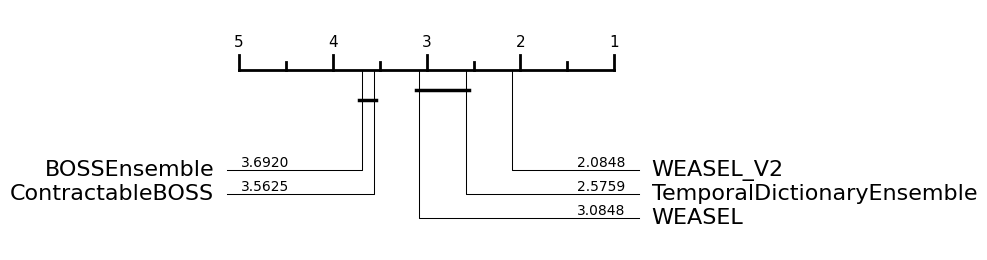

In [3]:
from aeon.visualisation import plot_boxplot_median, plot_critical_difference

plot_critical_difference(results, names)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

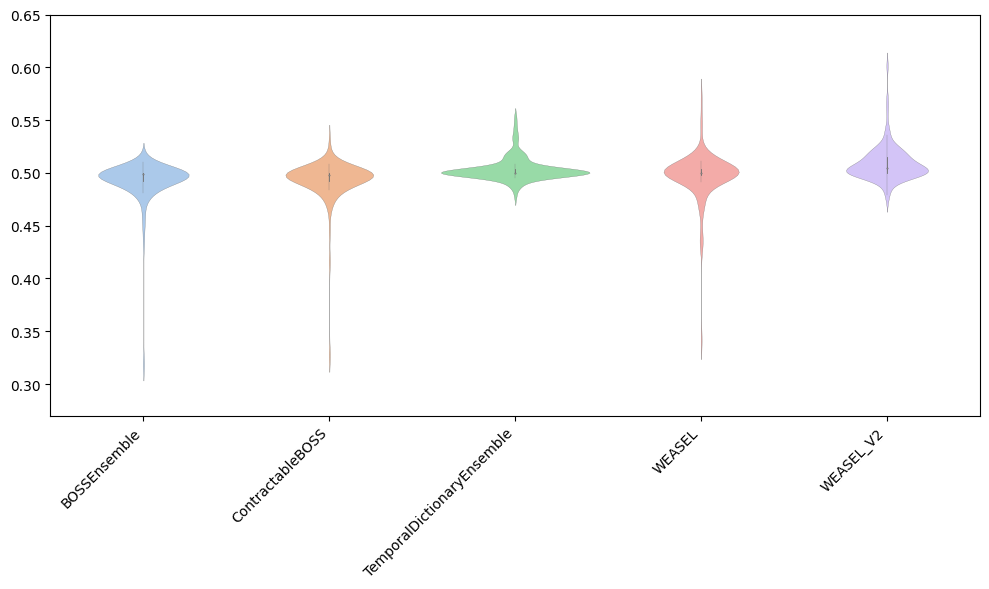

In [4]:
plot_boxplot_median(results, names)

#### References:

\[1\] Schäfer, P., & Högqvist, M. (2012). SFA: a symbolic fourier approximation and index for similarity search in high dimensional datasets. In Proceedings of the 15th International Conference on Extending Database Technology (pp. 516-527).

\[2\] Schäfer, P. (2015). The BOSS is concerned with time series classification in the presence of noise. Data Mining and Knowledge Discovery, 29(6), 1505-1530.

\[3\] Middlehurst, M., Vickers, W., & Bagnall, A. (2019). Scalable dictionary classifiers for time series classification. In International Conference on Intelligent Data Engineering and Automated Learning (pp. 11-19). Springer, Cham.

\[4\] Schäfer, P., & Leser, U. (2017). Fast and accurate time series classification with WEASEL. In Proceedings of the 2017 ACM on Conference on Information and Knowledge Management (pp. 637-646).

\[5\] Middlehurst, M., Large, J., Cawley, G., & Bagnall, A. (2020). The Temporal Dictionary Ensemble (TDE) Classifier for Time Series Classification. In The European Conference on Machine Learning and Principles and Practice of Knowledge Discovery in Databases.

\[6\] Large, J., Bagnall, A., Malinowski, S., & Tavenard, R. (2019). On time series classification with dictionary-based classifiers. Intelligent Data Analysis, 23(5), 1073-1089.

\[7\] Schäfer, P., & Leser, U. (2018). Multivariate time series classification with WEASEL+MUSE. 3rd ECML/PKDD Workshop on AALTD.

\[8\] Middlehurst, M., Schäfer, P., & Bagnall, A. (2023). Bake off redux: a review
and experimental evaluation of recent time series classification algorithms. [ArXive]
(https://arxiv.org/abs/2304.13029)